# **Machine Learning model**

## **Table of contents**

* [Our goals](#Our-goals)
* [The data](#The-data)
* [Methodology](#Methodology)
* [Models exploration and selection](#Models-exploration-and-selection)
    * [TF-IDF based model](#TF-IDF-based-model)
        * [Models pre-selection](#Models-pre-selection)
        * [Comparison and preliminary observations](#Comparison-and-preliminary-observations)
        * [Hyperparameters tuning and testing](#Hyperparameters-tuning-and-testing)
        * [Interpretation](#Interpretation)
        * [Understanding the mistakes](#Understanding-the-mistakes)
    * [Another model?](#Another-model?)
* [Setting up the final pipeline](#Setting-up-the-final-pipeline)
* [Advantages of ML](#Advantages-of-ML)
* [Conclusion and next steps](#Conclusion-and-next-steps)

In [1]:
import sys
import os
from pathlib import Path

project_root = str(Path(os.getcwd()).parent)
if project_root not in sys.path:
    sys.path.append(project_root)

from utilities import (
    plot_utilities, 
    preprocessing_utilities,
    ml_utilities
)

from utilities.plot_utilities import (
    Rstyle_spines,
    plot_classifiers_scores
)

from utilities.preprocessing_utilities import (
    parallel_process,
    clean_final_text_batch_spacy,
    extract_alternative_features
)

from utilities.ml_utilities import (
    generate_augmented_datasets,
    train_and_evaluate_classifiers,
    hypertune_models_bayesianCV,
    TextCleaner
)

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pickle
from functools import partial
from joblib import Parallel, delayed
from collections import Counter

import spacy
spacy.require_cpu()
nlp = spacy.load("en_core_web_sm")

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier
from skopt.space import Real, Integer, Categorical
from sklearn.metrics import classification_report

import shap
import lime
from lime.lime_text import LimeTextExplainer
import lime.lime_text

from IPython.core.magic import register_cell_magic
@register_cell_magic
def skip(line, cell):
    print("Cell skipped.")

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/czank/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
RANDOM_STATE = 42
NUM_WORKERS = 20
BATCH_SIZE = 64

## **Our goals**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
In this notebook, we will:  

* Set up the datasets to proceed with the training and evaluation of several classifiers.  
* Try classifiers based on semantic features (TF-IDF), as well as linguistic and sentiment-based features.  
* Use cross-validation to train and evaluate several classifiers and select the most promising one based on the F1-score.  
* Compare the performance of the models trained on the basic dataset versus the augmented one.  
* Use LIME and SHAP to understand and interpret our models.  
* Gain insights into why some misclassifications occurred.  
* Set up a final pipeline ready for deployment.
</div>

## **The data**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
In this section, we will set up the necessary datasets, including those augmented with newly rewritten news articles. All datasets will be cleaned, with the most predictive words removed, as presented in the EDA notebook. This step is intended to simplify and accelerate the training process. Normally, this step would take place in the final pipeline alongside the classifier we have chosen to use.
</div>

In [3]:
train_set = pd.read_csv("../data/train_set.csv", index_col=0)
test_set = pd.read_csv("../data/test_set.csv", index_col=0)

In [4]:
augmented_train_set, augmented_test_set = generate_augmented_datasets(train_set, test_set)

In [5]:
words_to_remove = ["image", "say", "said", "via", "video", "reuters", "like", "featured", "feature", "capture", "isn",
                   "watch", "getty", "even", "actually", "really", "screenshot", "screen", "wasn", "president",
                   "trump", "go", "get", "don", "know", "thing", "think", "tweet", "tweeter", "ll"
                   "facebook", "youtube", "happen", "seek", "let", "tweet", "trade", "mr", "republican",
                   "minister", "fact", "government", "official", "claim", "come", "hillary"
                   "didn", "ve", "spokesman", "s", "t", "word", "american", "americans", "didn"]

cleaned_train_set = parallel_process(train_set, 
                                     clean_final_text_batch_spacy, 
                                     num_workers=NUM_WORKERS, 
                                     nlp=nlp, 
                                     batch_size=BATCH_SIZE,
                                     words_to_remove=words_to_remove)

cleaned_augmented_train_set = parallel_process(augmented_train_set, 
                                               clean_final_text_batch_spacy, 
                                               num_workers=NUM_WORKERS, 
                                               nlp=nlp, 
                                               batch_size=BATCH_SIZE,
                                               words_to_remove=words_to_remove)

cleaned_test_set = parallel_process(test_set, 
                                     clean_final_text_batch_spacy, 
                                     num_workers=NUM_WORKERS, 
                                     nlp=nlp, 
                                     batch_size=BATCH_SIZE,
                                     words_to_remove=words_to_remove)

cleaned_augmented_test_set = parallel_process(augmented_test_set, 
                                     clean_final_text_batch_spacy, 
                                     num_workers=NUM_WORKERS, 
                                     nlp=nlp, 
                                     batch_size=BATCH_SIZE,
                                     words_to_remove=words_to_remove)

/home/czank/miniconda3/envs/dl_capstone/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|███████████████████████████████████████████| 20/20 [03:25<00:00, 10.26s/it]
/home/czank/miniconda3/envs/dl_capstone/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|███████████████████████████████████████████| 20/20 [03:41<00:00, 11.05s/it]
/home/czank/miniconda3/envs/dl_capstone/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
100%|███████████████████████████████████████████| 20

## **Methodology**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
Since our goal is to find the best classifier for detecting whether a news article is fake or not, we will experiment with different types of classifiers. All models will be trained and evaluated using 10-fold cross-validation. The classifiers to be tested include:  

* Random Forest  
* Gradient Boosting  
* AdaBoost  
* Decision Tree  
* K-Neighbors  
* Ridge  

</div>

In [6]:
n_splits = 10
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=RANDOM_STATE)

In [7]:
classifiers = {
    "random_forest": RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE),
    "gradient_boosting": GradientBoostingClassifier(n_estimators=200, max_depth=5, random_state=RANDOM_STATE),
    "ada_boost": AdaBoostClassifier(n_estimators=200, random_state=RANDOM_STATE),
    "decision_tree": DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
    "k_neighbors": KNeighborsClassifier(),
    "ridge": RidgeClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
}

## **Model exploration and selection**

### **TF-IDF based model**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
The first type of models we will explore are based on TF-IDF feature extraction. We will follow a similar approach to the one used during the EDA and limit the model to the 400 most abundant unigrams found in the entire dataset. This process will be applied to both the non-augmented and augmented datasets.
</div>

#### **Models pre-selection**

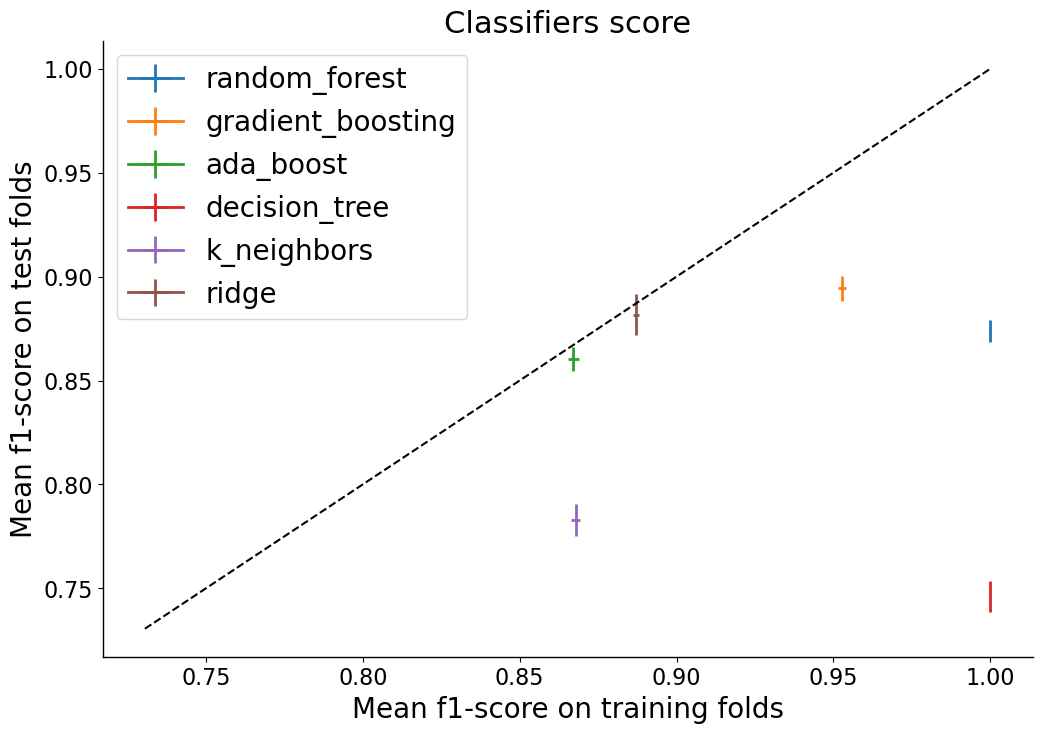

In [8]:
tfidf = TfidfVectorizer(
    strip_accents='unicode',
    max_features=400,
    lowercase=False,
    ngram_range=(1, 1)
)

tfidf.fit(cleaned_train_set["text"])

pipeline = Pipeline([("tfidf", TfidfVectorizer(vocabulary=tfidf.vocabulary_, )),
                     ("scaler", StandardScaler(with_mean=False))
                    ])

classifiers_scores = train_and_evaluate_classifiers(classifiers,
                                                    pipeline,
                                                    cleaned_train_set["text"],
                                                    cleaned_train_set["label"],
                                                    cv=skf,
                                                    scoring="f1")

fig, ax = plot_classifiers_scores(classifiers_scores)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
Overall, we see that most of our classifiers perform well. The final baseline established using our heuristic model was around 0.76 for the F1-score. All models outperform this baseline except for the Decision Tree, which is dramatically overfitting and requires adjustments to its hyperparameters.  

Nonetheless, we will focus on the top-performing models. The three best-performing classifiers are Gradient Boosting, Ridge, and Random Forest. However, both Gradient Boosting and Random Forest appear to be overfitting, as indicated by the performance gap between the training and test sets. The ultimate test of this will be their performance on unseen data, namely the test set.  

We will retain these three models and later tune their hyperparameters to further improve their performance.
</div>

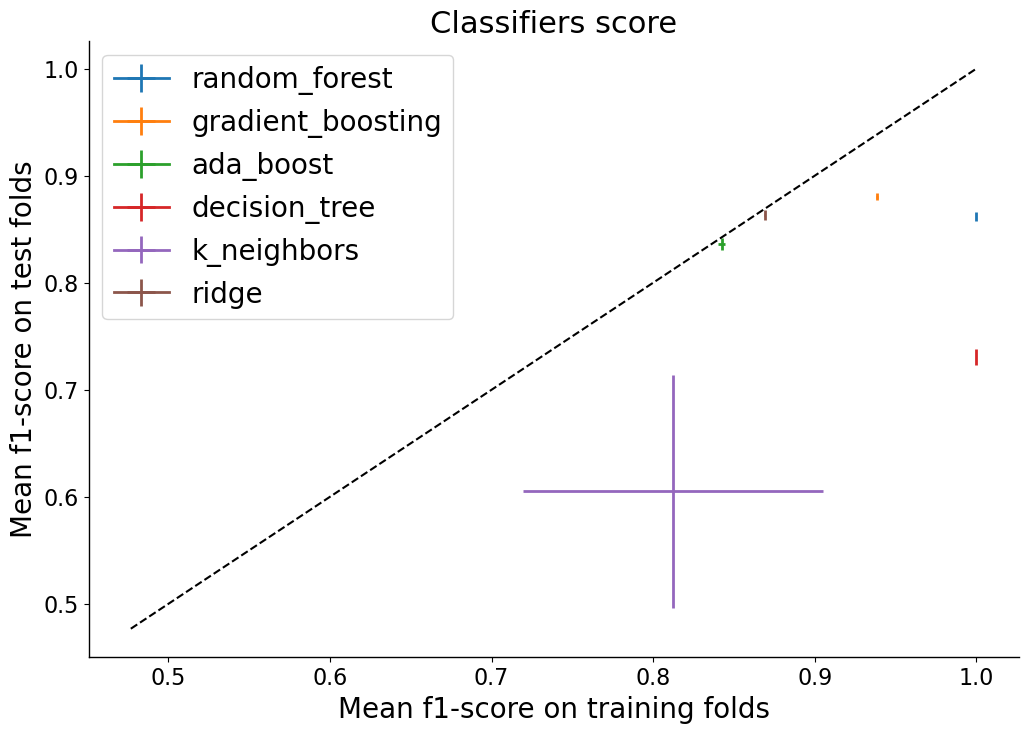

In [9]:
a_tfidf = TfidfVectorizer(
    strip_accents='unicode',
    max_features=400,
    lowercase=False,
    ngram_range=(1, 1)
)

a_tfidf.fit(cleaned_augmented_train_set["text"])

a_pipeline = Pipeline([("tfidf", TfidfVectorizer(vocabulary=a_tfidf.vocabulary_, )),
                     ("scaler", StandardScaler(with_mean=False))
                    ])

classifiers_scores_aug = train_and_evaluate_classifiers(classifiers,
                                                    a_pipeline,
                                                    cleaned_augmented_train_set["text"],
                                                    cleaned_augmented_train_set["label"],
                                                    cv=skf,
                                                    scoring="f1")

fig, ax = plot_classifiers_scores(classifiers_scores_aug)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
The models trained and evaluated on the augmented datasets generally perform similarly to those trained on the non-augmented dataset. However, a slight decrease in performance is noticeable on the augmented dataset. The newly introduced data may introduce some confusion, preventing the models from relying solely on the most common unigrams.  

Notably, the TF-IDF features used in this pipeline differ from those in the initial one, as the dataset as a whole has changed. A significant observation is that the K-Neighbors model appears to struggle with the new data. One hypothesis worth exploring is that the additional data may be blurring the cluster boundaries. This could be due to the increased presence of true news written in a social media style and fake news written in a journalistic style, leading to greater overlap between categories.
</div>

#### **Comparison and preliminary observations**

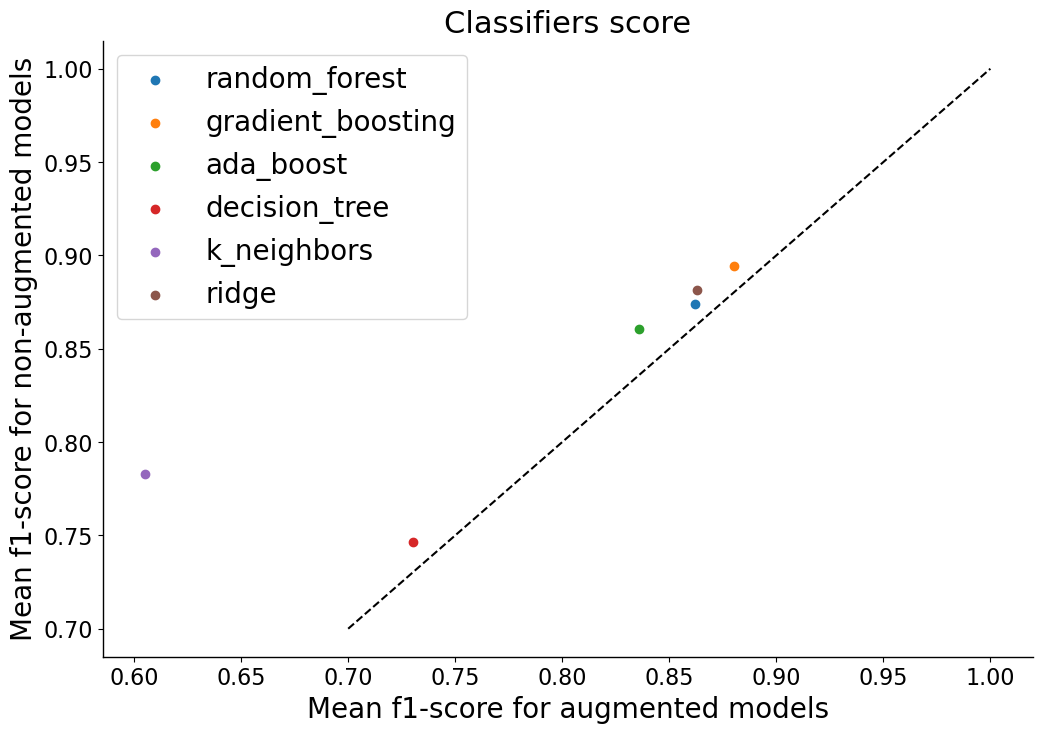

In [10]:
fig, ax = plt.subplots(figsize=(12, 8))
x = np.linspace(0.7, 1, 10)
ax.plot(x, x, color="k", ls="--")

for k in classifiers_scores_aug.keys():
    ax.scatter(np.mean(classifiers_scores_aug[k]["test_score"]), 
               np.mean(classifiers_scores[k]["test_score"]), 
               label=k)
    
ax.set_xlabel("Mean f1-score for augmented models", fontsize=20)
ax.set_ylabel("Mean f1-score for non-augmented models", fontsize=20)
ax.tick_params(axis="both", labelsize=16)
ax.set_title("Classifiers score", fontsize=22)
Rstyle_spines(ax, lw=1)
ax.legend(fontsize=20)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
As stated earlier and shown in the graph above, the models trained on the non-augmented dataset achieve a higher F1-score after cross-validation. Before proceeding to the testing phase, where we will evaluate our models on unseen data, we will first tune the hyperparameters of our best models for both the augmented and non-augmented datasets.
</div>

#### **Hyperparameters tuning and testing**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
The tuning process use bayesian optimization as it is often the ebst solution to quickly probe the hyperparameters space. These stes have been skipped as they can take some time (around one hour), especially the tuning of the gradient boosting model. Once the model are trained, we will evaluate them on the test set.

In [11]:
models_to_tune = {
    "ridge": {"model": RidgeClassifier(random_state=RANDOM_STATE, class_weight="balanced"),
              "param_space": {"alpha": Real(0.1, 2, prior="log-uniform")}
             },
    
    "gb": {"model": GradientBoostingClassifier(random_state=RANDOM_STATE),
           "param_space": {"learning_rate": Real(0.01, 1, prior="log-uniform"),
                           "n_estimators": Integer(150, 400),
                           "max_depth": Integer(3, 10)}
          },
    
    "rf": {"model":  RandomForestClassifier(class_weight="balanced", n_jobs=-1, random_state=RANDOM_STATE),
           "param_space": {"max_depth": Integer(2, 20),
                          "min_samples_split": Integer(2, 10),
                          "min_samples_leaf": Integer(1, 10)}
          }
}

In [12]:
%%skip
na_models_to_tune = hypertune_models_bayesianCV(models_to_tune,
                                                pipeline,
                                                cleaned_train_set["text"],
                                                cleaned_train_set["label"],
                                                skf,
                                                random_state=RANDOM_STATE)
                                                

with open("../pkl/models_to_tune.pkl", 'wb') as file:
    pickle.dump(na_models_to_tune, file)

Cell skipped.


In [13]:
with open("../pkl/models_to_tune.pkl", "rb") as file:
    models_to_tune = pickle.load(file)

In [14]:
for k, item in models_to_tune.items():
    predictions = item["best_model"].predict(cleaned_test_set["text"])
    print(f"{k}:\n")
    print(classification_report(predictions, cleaned_test_set["label"]))

ridge:

              precision    recall  f1-score   support

           0       0.91      0.92      0.91      4182
           1       0.90      0.88      0.89      3433

    accuracy                           0.90      7615
   macro avg       0.90      0.90      0.90      7615
weighted avg       0.90      0.90      0.90      7615

gb:

              precision    recall  f1-score   support

           0       0.94      0.92      0.93      4349
           1       0.89      0.93      0.91      3266

    accuracy                           0.92      7615
   macro avg       0.92      0.92      0.92      7615
weighted avg       0.92      0.92      0.92      7615

rf:

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      4433
           1       0.83      0.88      0.85      3182

    accuracy                           0.87      7615
   macro avg       0.87      0.87      0.87      7615
weighted avg       0.88      0.87      0.87      7615



<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
It is clear that the Gradient Boosting model outperforms the others by a small margin. However, its performance should be interpreted with caution. We are aware of the structural limitations of our dataset, and despite our best efforts, there may still be residual biases that artificially inflate the model's performance.
</div>

In [15]:
%%skip
a_models_to_tune = hypertune_models_bayesianCV(models_to_tune,
                                                a_pipeline,
                                                cleaned_augmented_train_set["text"],
                                                cleaned_augmented_train_set["label"],
                                                skf,
                                                random_state=RANDOM_STATE)
                                                

with open("../pkl/augmented_models_to_tune.pkl", 'wb') as file:
    pickle.dump(a_models_to_tune, file)

Cell skipped.


In [16]:
with open("../pkl/augmented_models_to_tune.pkl", "rb") as file:
    augmented_models_to_tune = pickle.load(file)

In [17]:
for k, item in augmented_models_to_tune.items():
    predictions = item["best_model"].predict(cleaned_augmented_test_set["text"])
    print(f"{k}:\n")
    print(classification_report(predictions, cleaned_augmented_test_set["label"]))

ridge:

              precision    recall  f1-score   support

           0       0.89      0.90      0.90      4257
           1       0.88      0.86      0.87      3558

    accuracy                           0.89      7815
   macro avg       0.88      0.88      0.88      7815
weighted avg       0.89      0.89      0.89      7815

gb:

              precision    recall  f1-score   support

           0       0.93      0.92      0.92      4409
           1       0.89      0.91      0.90      3406

    accuracy                           0.91      7815
   macro avg       0.91      0.91      0.91      7815
weighted avg       0.91      0.91      0.91      7815

rf:

              precision    recall  f1-score   support

           0       0.89      0.87      0.88      4477
           1       0.83      0.86      0.85      3338

    accuracy                           0.87      7815
   macro avg       0.86      0.87      0.86      7815
weighted avg       0.87      0.87      0.87      7815



<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
The performance of the models trained on the augmented dataset is comparable to those trained on the non-augmented dataset. In both cases, Gradient Boosting achieved the best performance, so we will select it to interpret our model and investigate the mistakes it made.
</div>

In [18]:
best_model = models_to_tune["gb"]["best_model"]
best_augmented_model = augmented_models_to_tune["gb"]["best_model"]

#### **Interpretation**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
For the interpretation of the model, we will use tools such as LIME and SHAP to help us unpack the mysteries of our model. These two interpreters rely on different techniques: while SHAP provides a game-theory-oriented explanation, LIME uses perturbation of the original dataset to reveal the importance of each feature. The latter will also be useful later when investigating the origins of our model's mistakes.  

We will start with SHAP, as it comes with a global interpreter that provides an overview of the profile and importance of our model's main features. In this case, since we used the most common unigrams, it will highlight the most predictive unigrams and indicate in which direction they tend to influence the model's decisions.
</div>

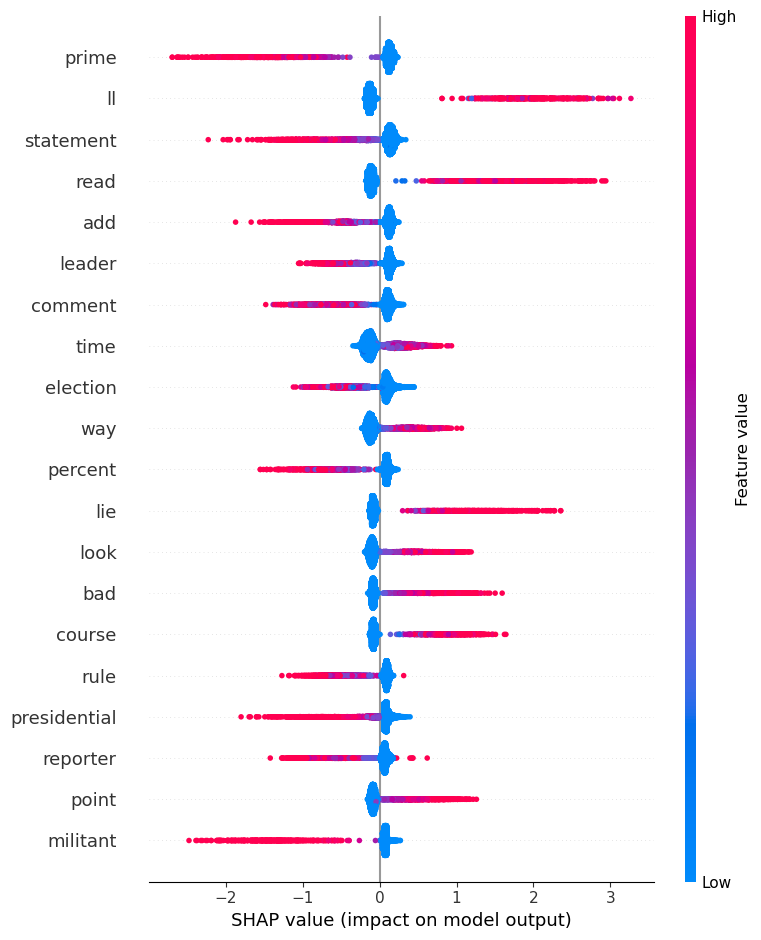

In [19]:
explainer = shap.TreeExplainer(best_model["gb"])
cleaned_test_set_tfidf = best_model[:-1].transform(cleaned_test_set["text"])
shap_values = explainer.shap_values(cleaned_test_set_tfidf.toarray())
shap.summary_plot(shap_values, cleaned_test_set_tfidf.toarray(), feature_names = tfidf.get_feature_names_out())

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
As we can see from above, the unigrams with the best predictive power are quite similar to those we found in the EDA earlier. Even after thorough cleaning, including removing many words with specific political meanings, we still find words such as `prime` (for prime minister), `election`, `militant`, `presidential`, etc., among the top predictive unigrams. Most of these words drive the model toward predicting true news. The word `ll`, which comes from the contraction "I’ll" or "we’ll", could not be removed, even though it was included in the list of words to remove. Other words related to traditional media, such as `statement`, `comment`, and `reporter`, also tend to push the model toward true news. Words with a negative resonance, such as `bad` or `lie`, drive the model in the opposite direction. It is also intriguing to find words with a more neutral meaning, such as `read`, `add`, or `point`, having such significant predictive power.

It is now time to move on to the LIME interpretation. To do this, we will need to evaluate the dataset entries one by one, as there is no API providing a direct global interpretation. This process is quite lengthy, so it will be skipped. The results can be found in the `../pkl` directory.
</div>

In [20]:
%%skip
def explain_text(text):
    explainer = LimeTextExplainer()
    explanation = explainer.explain_instance(text, best_model.predict_proba, num_features=10)
    return explanation.as_list()

sample_texts = cleaned_test_set["text"].tolist()

results = Parallel(n_jobs=-1)(delayed(explain_text)(text) for text in sample_texts)

lime_feature_importance = Counter()
for explanation in results:
    for word, weight in explanation:
        lime_feature_importance[word] += weight

sorted_lime_features = sorted(lime_feature_importance.items(), key=lambda x: abs(x[1]), reverse=True)

with open("../pkl/sorted_lime_features.pkl", 'wb') as file:
    pickle.dump(sorted_lime_features, file)

Cell skipped.


In [21]:
with open("../pkl/sorted_lime_features.pkl", "rb") as file:
    sorted_lime_features = pickle.load(file)

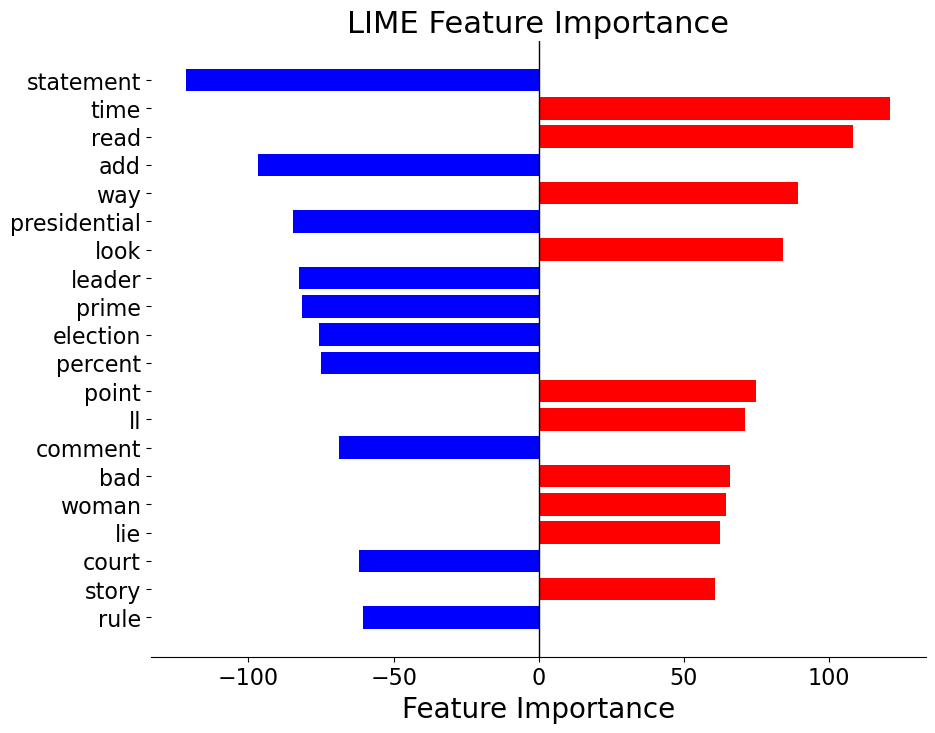

In [22]:
words, values = zip(*sorted_lime_features[:20])

colors = ['red' if v > 0 else 'blue' for v in values]

fig, ax = plt.subplots(figsize=(10, 8))
ax.barh(words, values, color=colors, align='center')
ax.set_xlabel("Feature Importance", fontsize=20)
ax.set_title("LIME Feature Importance", fontsize=22)
ax.invert_yaxis() 
ax.tick_params(axis="both", labelsize=16)
plt.axvline(x=0, color='black', linewidth=1) 
for spine in ax.spines.values():
    spine.set_visible(False)
ax.spines['bottom'].set_visible(True)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
The interpretation provided by the LIME interpreter does not differ significantly from the one given by SHAP. This reinforces our confidence that the features presented above are undoubtedly the most important, as both LIME and SHAP, along with previous measures taken during the EDA, tend to agree. Now that we have established a global interpretation, we can use the LIME local interpreter to investigate the mistakes made by our models.
</div>

#### **Understanding the mistakes**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
We will start by focusing on the Gradient Boosting model trained on the non-augmented dataset.
</div>

In [23]:
predictions = best_model.predict(cleaned_test_set["text"])
mistakes = cleaned_test_set[predictions != cleaned_test_set["label"]]
false_positives = mistakes[mistakes["label"] == 0]
false_negatives = mistakes[mistakes["label"] == 1]

In [24]:
explainer = LimeTextExplainer()
explanation = explainer.explain_instance(false_positives.loc[10897, "text"], 
                                         best_model.predict_proba, num_features=10)
explanation.show_in_notebook()

In [25]:
test_set.loc[10897, "text"]

'President Barack Obama, taking on Republican presidential candidates for stirring up anxiety among Americans, told leaders at Washington’s national prayer breakfast on Thursday that faith could conquer fear brought on by war, technology, and economic troubles. “It is a primal emotion, fear, one that we all experience.\xa0 And it can be contagious, spreading through societies, and through nations,” Obama said. “For me, and I know for so many of you, faith is the great cure for fear.\xa0Jesus is a good cure for fear.\xa0God gives believers the power, the love, the sound mind required to conquer any fear.\xa0And what more important moment for that faith than right now?” he said. Obama’s remarks came a day after his first visit to a U.S. mosque, where he sought to allay fears of Americans accustomed to pop-culture portrayals of Muslims as terrorists and to reassure Muslim American youth about their identity. Republican presidential front-runner Donald Trump has called for a temporary ban 

In [26]:
explanation = explainer.explain_instance(false_negatives.loc[35981, "text"], 
                                         best_model.predict_proba, num_features=10)
explanation.show_in_notebook()

In [27]:
test_set.loc[35981, "text"]

'Huh? Do these people live in a bubble or what? It s almost like they re sticking their fingers in their ears singing La, La, La WTH! (VIDEO) AS RAMADI FALLS TO ISIS, YOU’LL NEVER GUESS WHAT THE WHITE HOUSE HAS TO SAY ABOUT IT'

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
The two examples above highlight the limitations of TF-IDF unigram-based models. Since a unigram does not provide any context, the same word can be used in both positive and negative ways but will still be interpreted equally by the model. The first example illustrates this clearly: the word "Muslim" has been used repeatedly in a fake news context, particularly by media outlets supporting Trump during his presidential campaign. As a result, any other news piece discussing Muslims in neutral or positive terms will likely be associated with the large number of fake news articles related to the term.

The second example, a false negative, demonstrates another limitation of our model. Our dataset contains texts of varying lengths, and a TF-IDF-based classifier requires a sufficiently large amount of text to make accurate predictions. The example above shows that many of the words present were not even part of the TF-IDF vocabulary, leading to inaccurate classification.
</div>

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
Before drawing any general conclusions, let's evaluate how our model, trained on the non-augmented dataset, performs on the rewritten news that it has never seen during training. We will then compare this performance with that of the model trained on the rewritten news.
</div>

In [28]:
print(classification_report(best_model.predict(cleaned_augmented_test_set.loc[augmented_test_set[-200:].index, "text"]), 
                            cleaned_augmented_test_set.loc[augmented_test_set[-200:].index, "label"]))

              precision    recall  f1-score   support

           0       0.71      0.61      0.66       116
           1       0.55      0.65      0.60        84

    accuracy                           0.63       200
   macro avg       0.63      0.63      0.63       200
weighted avg       0.64      0.63      0.63       200



In [29]:
print(classification_report(best_augmented_model.predict(cleaned_augmented_test_set.loc[augmented_test_set[-200:].index, "text"]), 
                            cleaned_augmented_test_set.loc[augmented_test_set[-200:].index, "label"]))

              precision    recall  f1-score   support

           0       0.87      0.86      0.87       101
           1       0.86      0.87      0.86        99

    accuracy                           0.86       200
   macro avg       0.86      0.87      0.86       200
weighted avg       0.87      0.86      0.87       200



<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
It was expected that the model not trained on rewritten news would likely underperform, but the magnitude of underperformance is quite striking. While it scored an F1 of around 0.92 on other news, it does not even reach 0.65 when tested on rewritten news. This strengthens our conviction that the differing origins of the news—social media for fake news and Reuters for true news—do not allow for a reliable classifier, as it could be easily fooled by simply changing the form of the content without altering the underlying idea.  

This also reinforces my belief that the model trained on augmented data could generalize better. Since the form of news can be altered so easily, we need a model that can look beyond the superficial structure. In the meantime, TF-IDF-based models might be too simplistic to handle this task, which is why we will later train and evaluate models based on non-TF-IDF features, such as linguistic or sentiment-based features.

Before doing that, let's examine whether the feature interpretations by SHAP differ between the models trained on regular and augmented data.
</div>

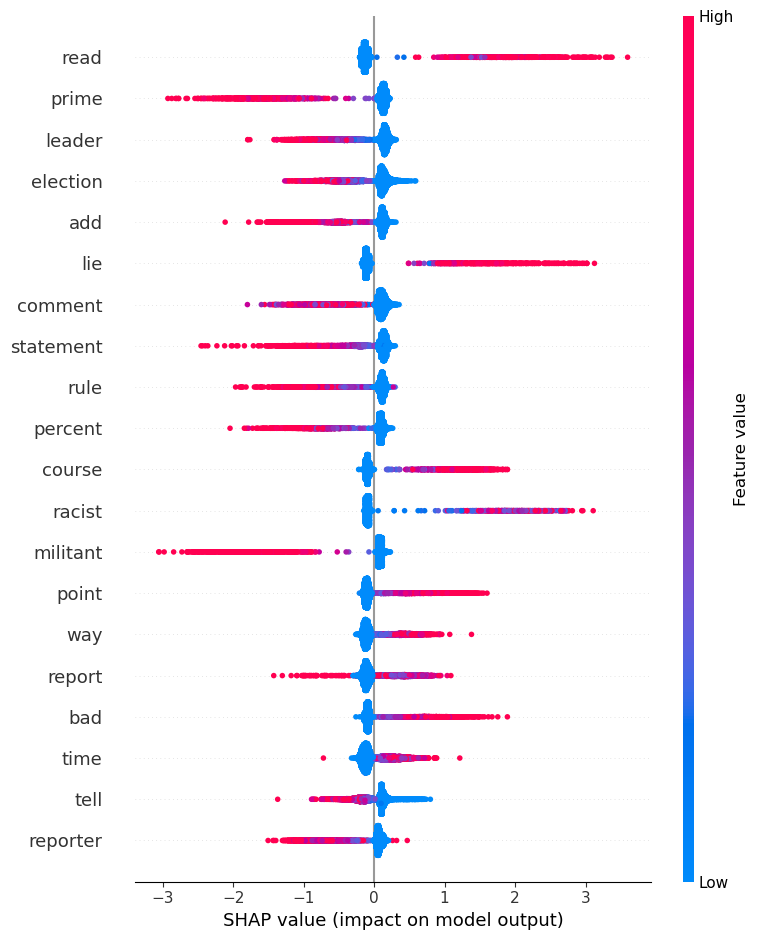

In [30]:
explainer = shap.TreeExplainer(best_augmented_model["gb"])
cleaned_augmented_test_set_tfidf = best_augmented_model[:-1].transform(cleaned_augmented_test_set["text"])
shap_values = explainer.shap_values(cleaned_augmented_test_set_tfidf.toarray())
shap.summary_plot(shap_values, cleaned_augmented_test_set_tfidf.toarray(), feature_names = a_tfidf.get_feature_names_out())

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
We can observe some minor differences between the SHAP summary plot for the model trained on augmented data and the one for the non-augmented dataset. Most of the differences involve the order of feature importance, but overall, the plots are quite similar.

Now that we have trained and tested a TF-IDF-based model, we’d like to give another type of model a chance. Why is that? The most important reason is that a TF-IDF model might generalize poorly when used on datasets of different topics. For example, in our case, it could struggle with scientific fake news, as the TF-IDF vocabulary was extracted from a dataset that predominantly contains political news. Therefore, it could be worthwhile to train a model based on other features, such as linguistic or sentiment analysis-based features.
</div>

### **Another model?**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
As we mentioned earlier, a TF-IDF-based model might struggle with generalization since it relies on the vocabulary of the dataset it was trained on. In our case, the TF-IDF model will almost exclusively focus on political lexicon. Additionally, as we have seen, a model trained to detect structural differences between fake and true news—where the latter is mostly extracted from social networks—will also be a poor detector. It would likely be easy to deceive, as anyone could rewrite a fake news article in a journalistic style (using an LLM, for example) to make it appear legitimate. Therefore, an alternative approach would be to create a model that leverages linguistic features (e.g., readability) or aspects such as polarity and sensitivity.
</div>

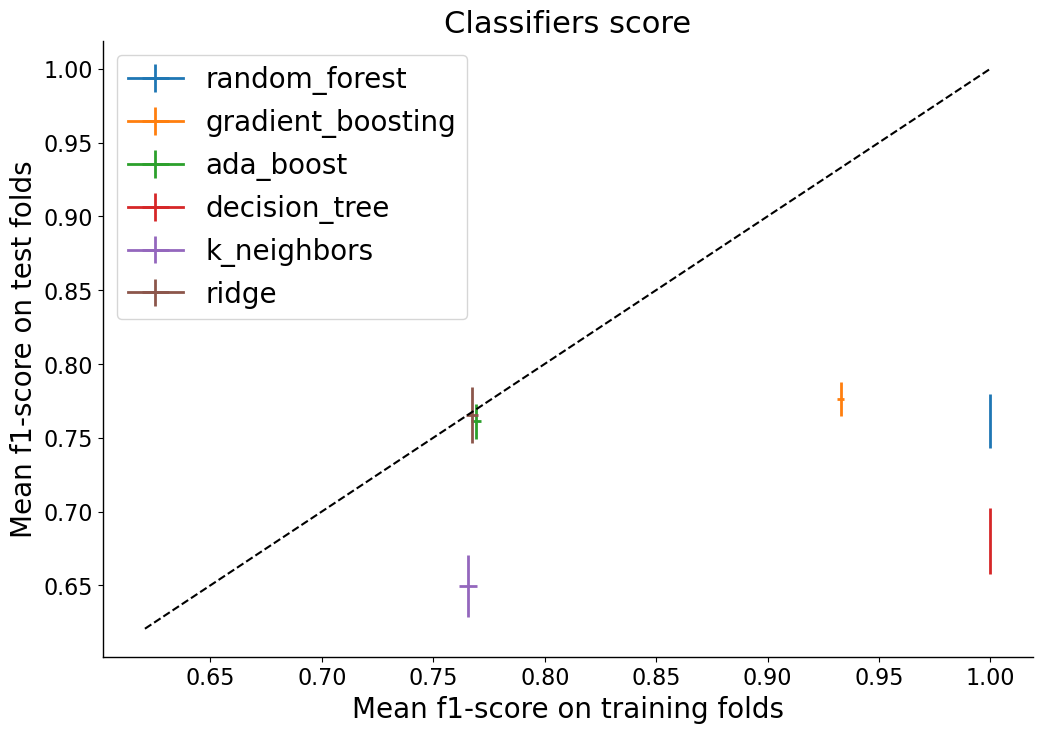

In [31]:
alternative_features = extract_alternative_features(cleaned_test_set)
X_train = alternative_features.drop(["label"], axis=1)
y_train = alternative_features["label"]

pipeline = Pipeline([
                    ])

classifiers_scores = train_and_evaluate_classifiers(classifiers,
                                                    pipeline,
                                                    X_train,
                                                    y_train,
                                                    cv=skf,
                                                    scoring="f1")

fig, ax = plot_classifiers_scores(classifiers_scores)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
As we can see, the F1 scores of the best classifiers are very low. While tuning the hyperparameters could lead to slight improvements, it is unlikely to bring these classifiers to the performance level of the TF-IDF-based model. Since the highest scores are comparable to our heuristic baseline model, it would be preferable to stick with the previous TF-IDF model.
</div>

## **Setting up the final pipeline**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
    
In the future, this model will need to be deployed, so we must set up the final pipeline. To streamline and accelerate the previous steps, we pre-cleaned the entire dataset. However, in a real-world scenario, the input text will be raw, which is why we need to include a text cleaning function at the beginning of our pipeline. To achieve this, we integrate the `clean_final_text_batch_spacy` function into a custom scikit-learn transformer.
</div>

In [32]:
final_pipeline = Pipeline([("cleaner", TextCleaner(partial(clean_final_text_batch_spacy, nlp=nlp)))] 
                          + best_augmented_model.steps)

## **Advantages of ML**

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
We have extensively discussed the limitations of our ML model, particularly its potential issues with generalization and susceptibility to manipulation. Later, we will train and test a DL-based model that should help mitigate these shortcomings.  

Before moving forward, it's important to highlight the advantages of ML models. We've already discussed how easy it is to extract feature importance and interpret the model, but another key benefit is inference speed. Additionally, an ML model does not necessarily require GPU access to run efficiently.  

With that in mind, let's quantify the inference time of our selected model.
</div>

In [33]:
test_set_sample = augmented_test_set.sample(1000)
X_test = test_set_sample["text"]
y_test = test_set_sample["label"]

In [34]:
inference_times = []

for i in range(0, X_test.shape[0]-1):
    start_time = time.time()  
    final_pipeline.predict(X_test[i:i+1])  
    end_time = time.time()  
    inference_times.append(end_time - start_time)  

inference_times = [1000 * t for t in inference_times]

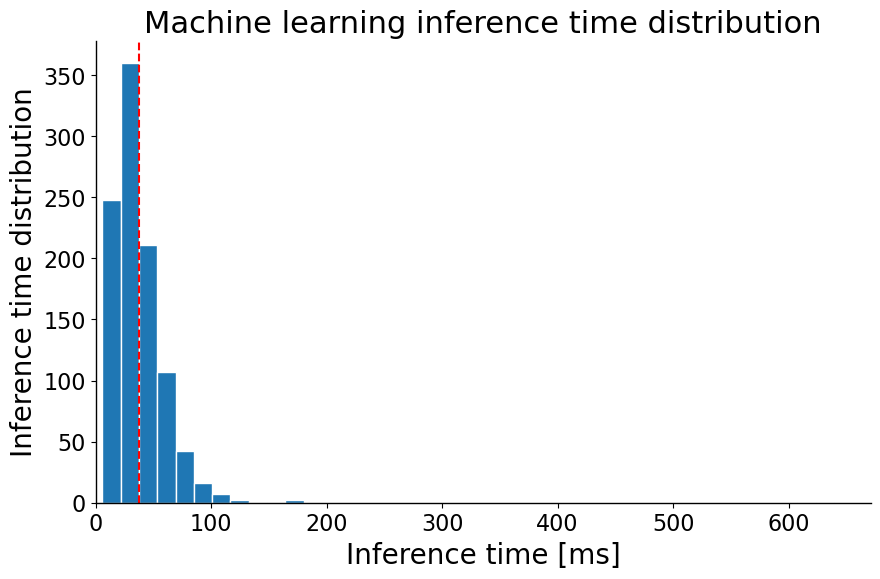

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(inference_times, bins=40, edgecolor="w")
ax.set_xlim(left=0)
Rstyle_spines(ax, lw=1)
mean_inference_times = np.mean(inference_times)
ax.axvline(x=mean_inference_times, zorder=2, color="r", linestyle="--")
ax.set_xlabel("Inference time [ms]", fontsize=20)
ax.set_ylabel("Inference time distribution", fontsize=20)
ax.set_title("Machine learning inference time distribution", fontsize=22)
ax.tick_params(axis="both", labelsize=16)

<div style="background-color: #e8f4f8; padding: 10px; border-radius: 5px;">
The inference time ranges between 10 and 500 milliseconds, with an average of around 39 milliseconds. Given that we are using a CPU, this is quite fast, making the model suitable for deployment in portable applications.
</div>

## **Conclusion and next steps**

<div style="background-color: #f8d7dA; padding: 10px; border-radius: 5px;">
    
In this notebook, we have:  

* Trained and tested multiple classifiers to determine which one performs best (around 0.9).  
* Compared the results of models trained on the non-augmented and augmented datasets.  
* Found that the model trained on the augmented dataset is likely to generalize better, as it performed significantly better at classifying rewritten news.  
* Used SHAP and LIME to interpret our model, comparing both methods and confirming that, despite using different techniques, they produce similar insights.  
* Identified and analyzed the mistakes made by our top classifier.  
* Trained and tested models using features beyond TF-IDF and observed that they could not match its performance.  
* Set up the final pipeline and quantified its inference time.
</div>